In [209]:
import cv2
import numpy as np
from IPython.display import display
from PIL import Image, ImageOps, ImageDraw
from tqdm import tqdm
import seaborn as sns
import pandas as pd

In [210]:
vidcap = cv2.VideoCapture('../xenoblade.mp4')
if not vidcap.isOpened():
    print('could not open capture')
    exit()


In [211]:
#Get Stats about video
length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = vidcap.get(cv2.CAP_PROP_FPS)

print(width, height, length, fps)

1280 720 1161247 60.0


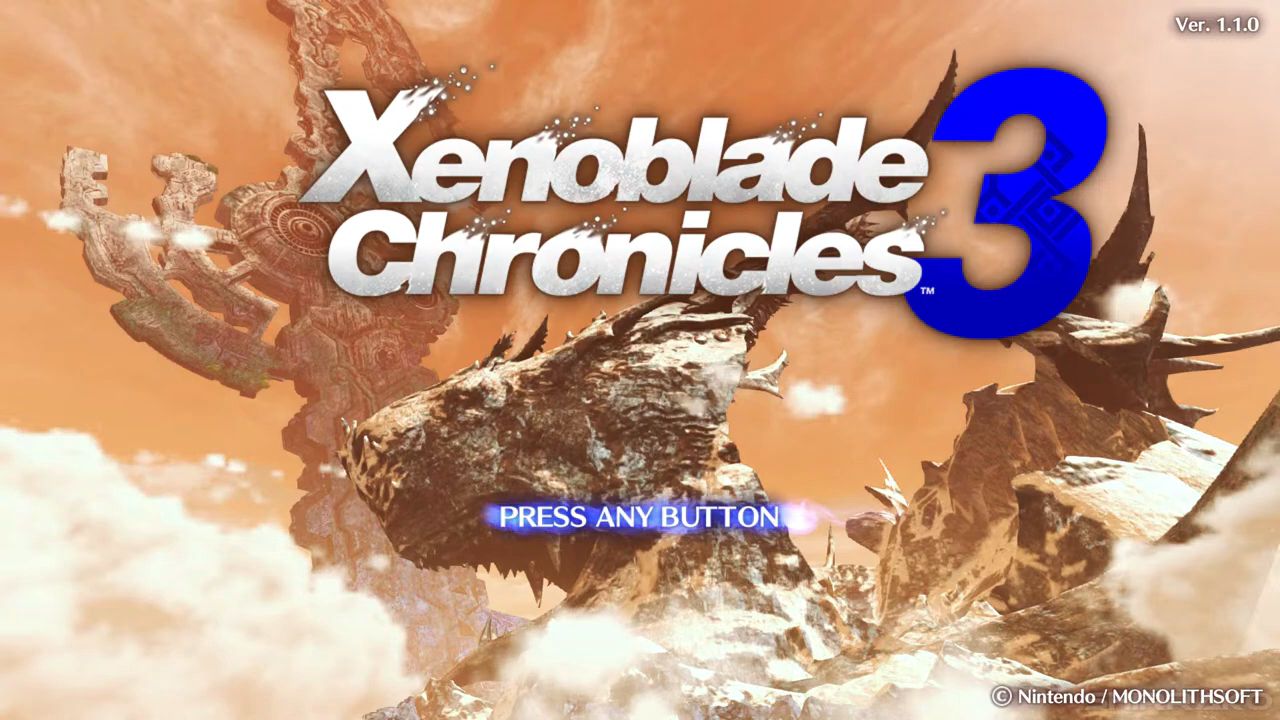

In [212]:

# Get and display first frame
_, image = vidcap.read()
# Read frame as numpy array
f1 = Image.fromarray(image, 'RGB')
display(f1)

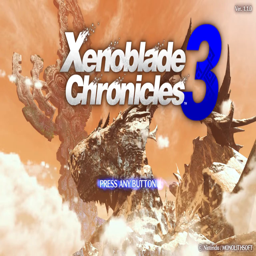

In [213]:
# Resize to smaller size
f1 = f1.resize((256, 256))
display(f1)

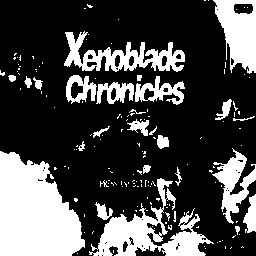

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


In [214]:
# MonoChrome
thresh = 200
fn = lambda x : 255 if x > thresh else 0
f1 = f1.convert('L').point(fn, mode='1')
display(f1)
# Recast as numpy array of True/False
f1np = np.asarray(f1)
print(f1np)

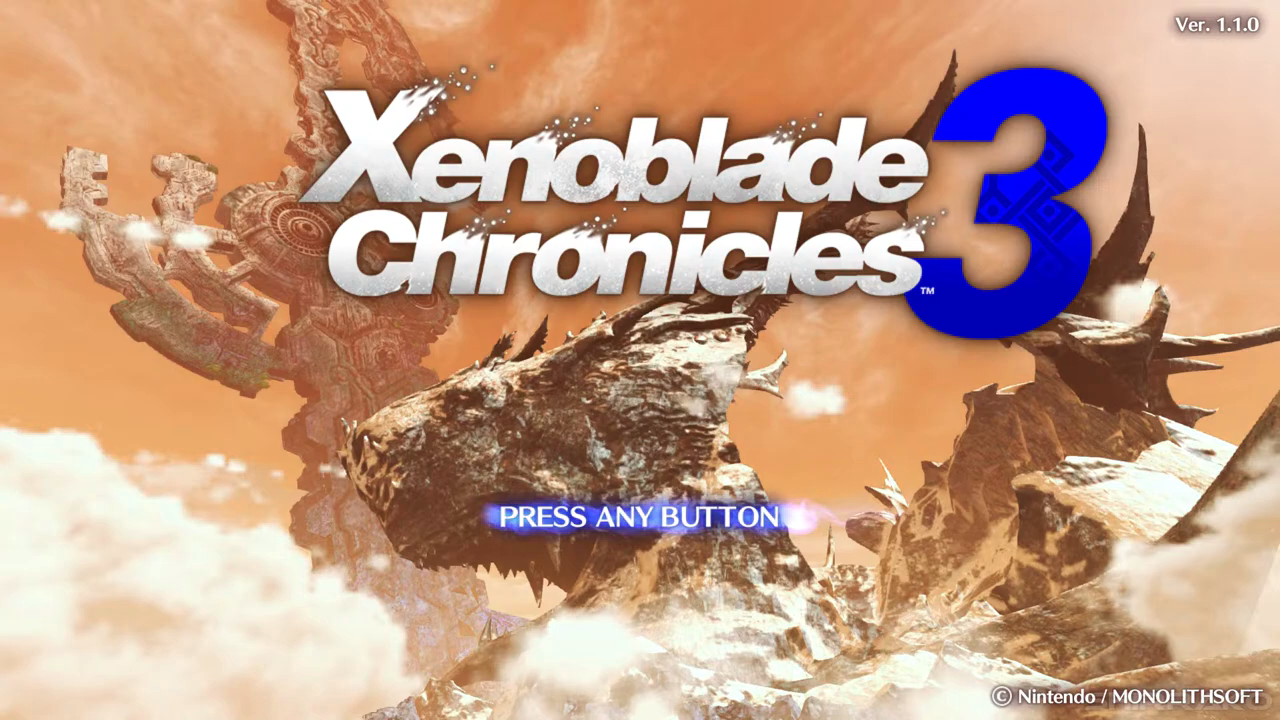

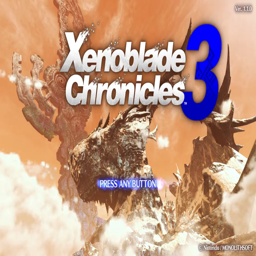

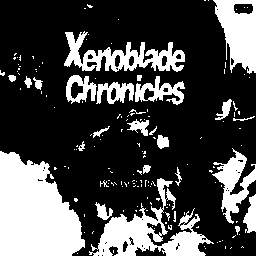

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


In [215]:
#Get the next frame and do the same thing
_, image = vidcap.read()
# Read frame as numpy array
f2 = Image.fromarray(image, 'RGB')
display(f2)
# Resize to smaller size
f2 = f2.resize((256, 256))
display(f2)
# MonoChrome
thresh = 200
fn = lambda x : 255 if x > thresh else 0
f2 = f2.convert('L').point(fn, mode='1')
display(f2)
# Recast as numpy array of True/False
f2np = np.asarray(f2)
print(f2np)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


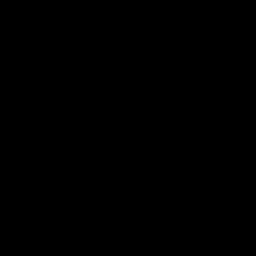

Number of differing pixels: 6


In [216]:
#Get a diff of the 2 frames
#0 xor 0 = 0
#1 xor 1 = 0
#1 xor 0 = 1
#0 xor 1 = 1
#EX: The end result will only have True where pixels were different between frames
frameDiff = np.logical_xor(f1, f2)
print(frameDiff)

# Visualize the diff
display(Image.fromarray(frameDiff, 'L'))

#Get the count of different pixels
print("Number of differing pixels:", np.count_nonzero(frameDiff == True))

In [217]:
# Now that we have our main logic for diffing frames let's loop through the first 10k frames
# and count the pixels that went bright-->dark, or dark-->bright
# Use functions to make it cleaner

def getNextFrameNp(vidcap):
    _, image = vidcap.read()
    f = Image.fromarray(image, 'RGB').resize((256, 256))
    thresh = 200
    fn = lambda x : 255 if x > thresh else 0
    f = f.convert('L').point(fn, mode='1')
    return np.asarray(f)

frameCount = 10000

output = np.zeros(frameCount)

#Starting Frame
prevFrame = getNextFrameNp(vidcap=vidcap)

for frame in tqdm(range(frameCount)):
    #Next Frame
    currFrame = getNextFrameNp(vidcap=vidcap)
    #Get Diff
    frameDiff = np.logical_xor(prevFrame, currFrame)
    #Append count of differing pixels to output
    diffCount = np.count_nonzero(frameDiff == True)
    #print(diffCount)
    output[frame] = int(diffCount)
    #Set currFrame to prevFrame for next round
    prevFrame = currFrame

print(output)

100%|██████████| 10000/10000 [01:03<00:00, 156.75it/s]

[ 1. 47. 22. ...  0.  0.  0.]


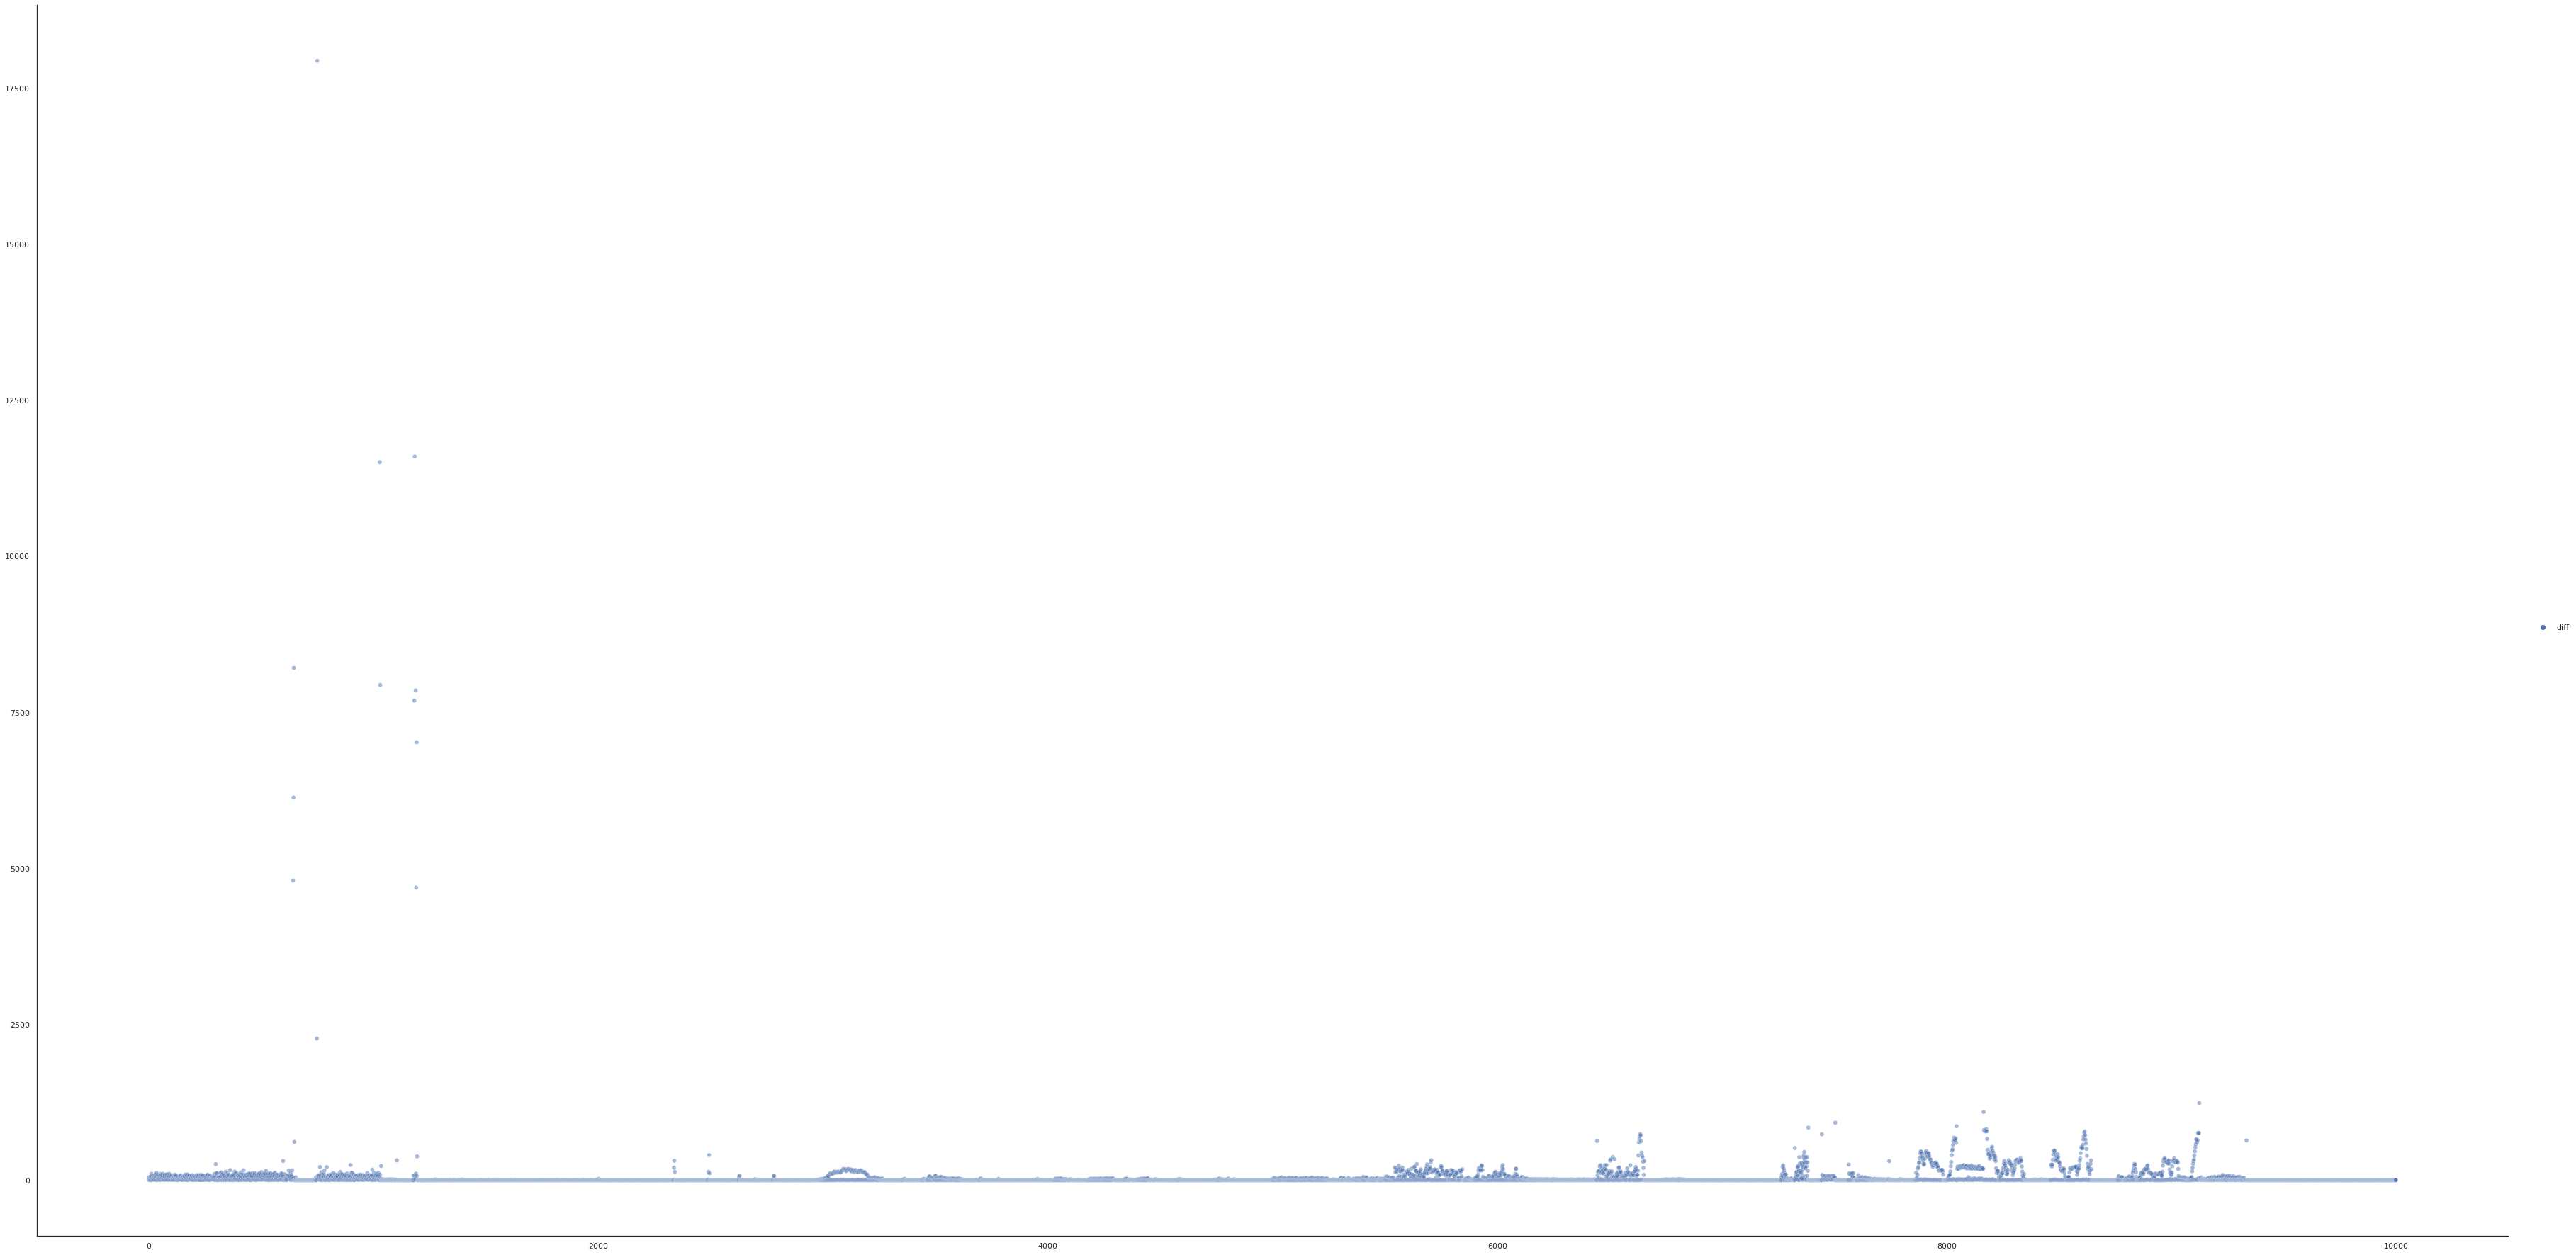

In [218]:
# Let's plot it

sns.set_theme(style="white")
odf = pd.DataFrame({"diff": output})
sns.relplot(data=odf, alpha=.5, height=25, aspect=50/25)

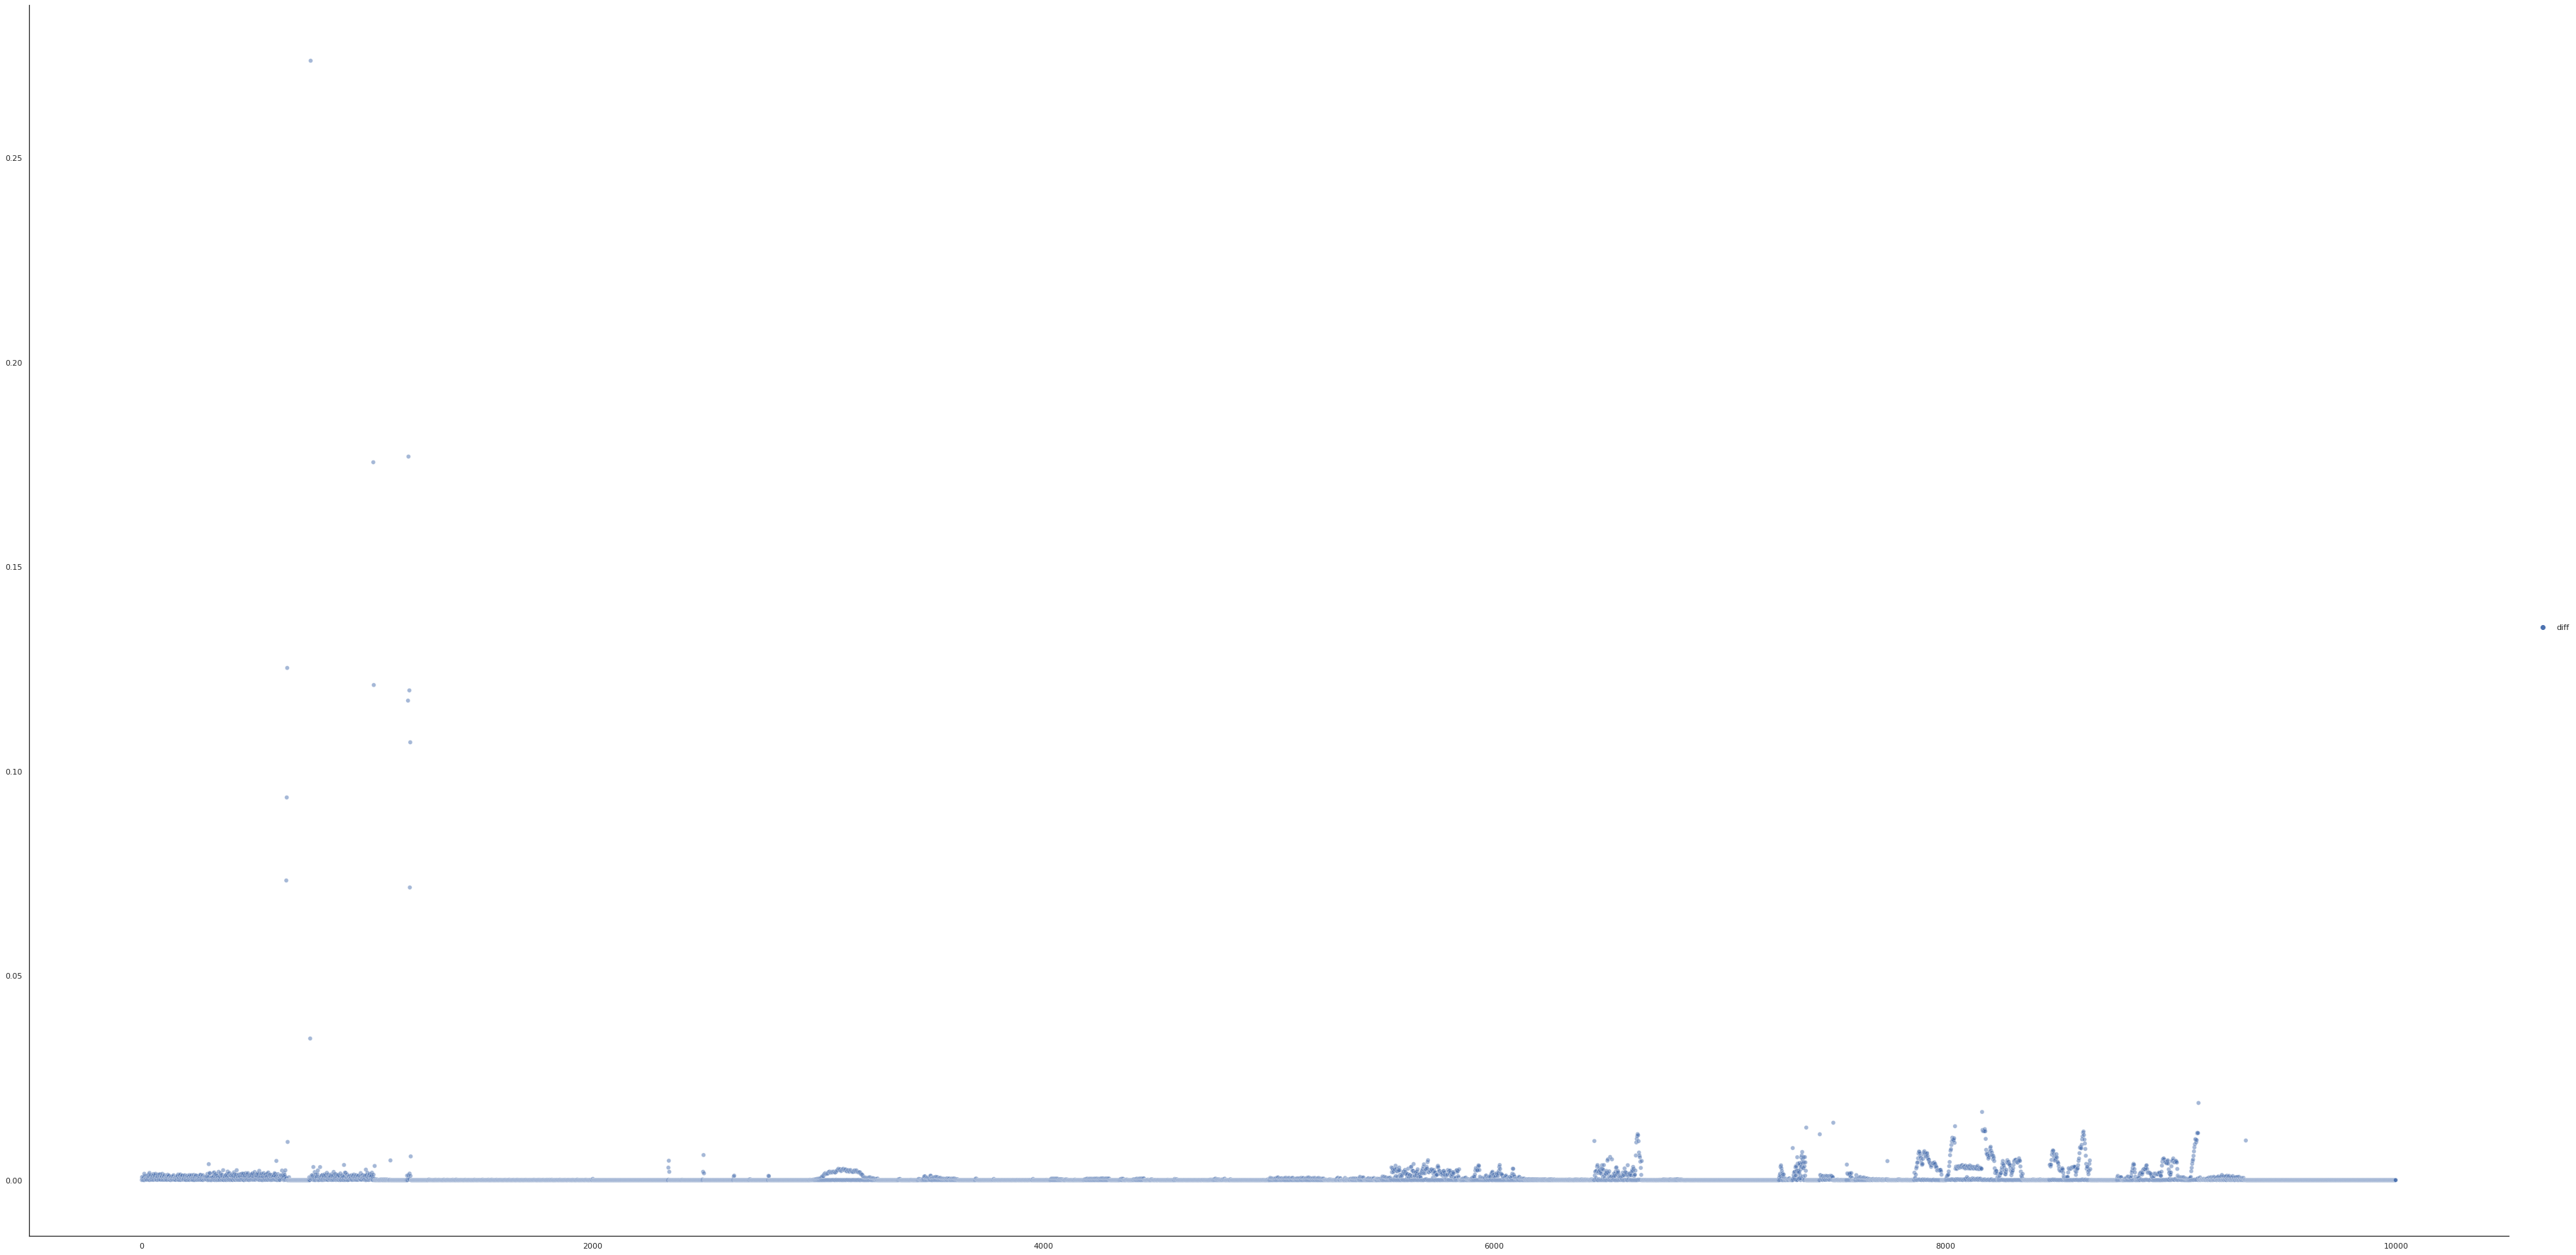

In [219]:
# Very cool!
# But this is graphing a scatterplot of pixels changed per frame
# We know that due to resizing there is 256x256 pixles per frame
# Let's re-scale as frameDiff divided by (256x256) to get a percent of each frame which flashed, giving us a y axis of 0-->1
# Where 1 being that the entire frame flashed, and 0 being that the frame didn't flash at all

output = np.divide(output, (256*256))
odf = pd.DataFrame({"diff": output})
sns.relplot(data=odf, alpha=.5, height=25, aspect=50/25)

749


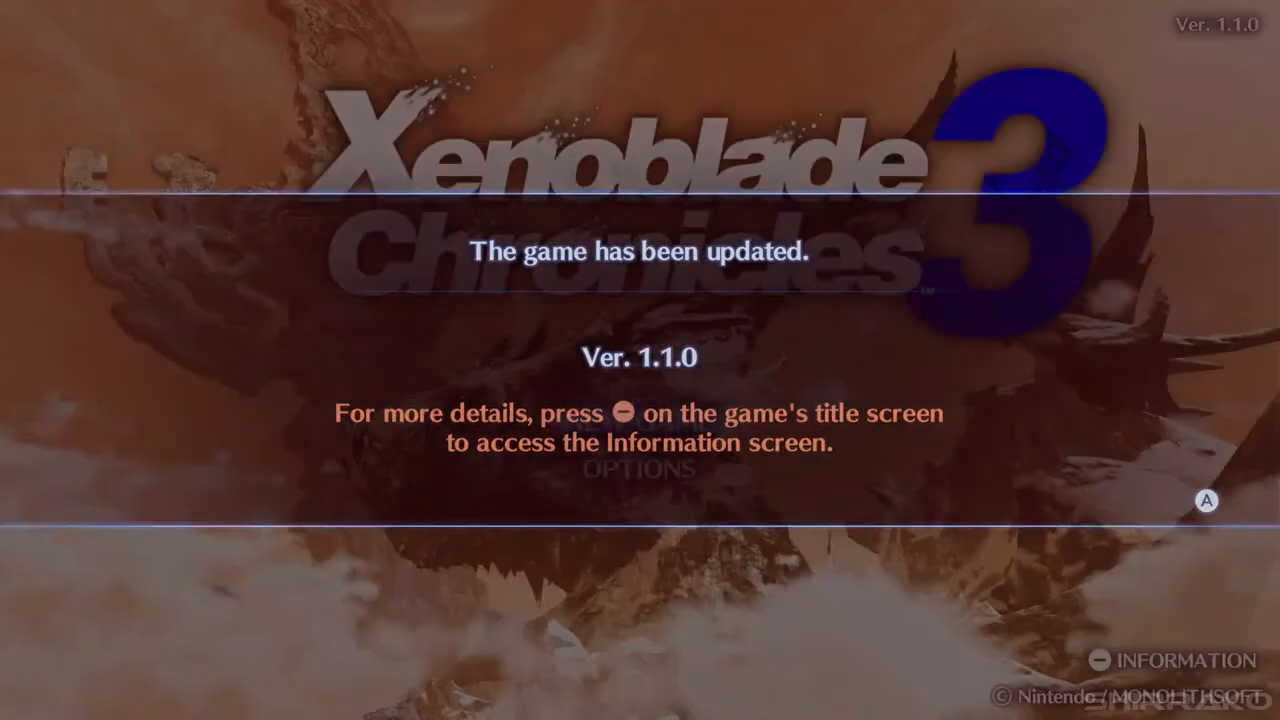

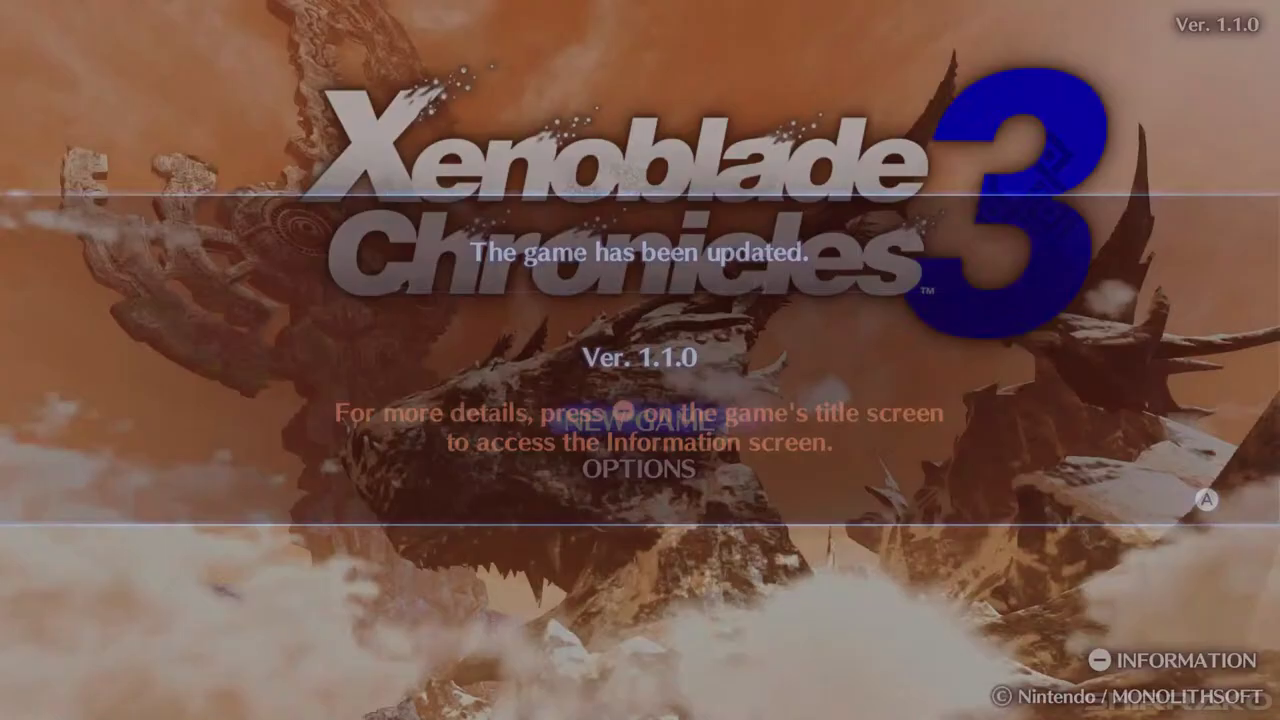

In [227]:
# We can see that for the first 10k frames only a single screen flash occurred which occupied >25% of the frame
# get that frame index and the one prior to it. Display the images.
flashFrameIndex = np.where(output>0.25)[0][0]
print(flashFrameIndex)
prevFlashFrameIndex = flashFrameIndex -1

vidcap.release()
vidcap = cv2.VideoCapture('../xenoblade.mp4')
if not vidcap.isOpened():
    print('could not open capture')
    exit()

# Read and discard frames until we get where we want to be
for i in range(prevFlashFrameIndex - 1):
    _, _ = vidcap.read()

_, image = vidcap.read()
f1 = Image.fromarray(image, 'RGB')
display(f1)

_, image = vidcap.read()
f2 = Image.fromarray(image, 'RGB')
display(f2)


In [ ]:
# As you can see, a ~25% flash is not something drastic, but we CAN detect it.
# Setting a threshold for something like >80% frame flash would detect

# Then of course, you'd want to run the same functions against multiple playthroughs as different players complete the game at different rates.
# Casting the output of flashing frames as a signal, you'd perform a Fast Fourier Transform (FFT) https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft
# Resampling each playthrough for the time domain, and comparing similarity in the power domain.
# Whereever similarities exist between signals, you can reasonably expect a given player to see a screen flash at defined timestamps.